In [25]:
#Imports + initializing tables
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from pandas import DataFrame

from sympy import symbols,diff
from math import log

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drive = pd.read_csv('./dataset/drivers.csv')
result = pd.read_csv('./dataset/results.csv')
race = pd.read_csv('./dataset/races.csv')
construct = pd.read_csv('./dataset/constructors.csv')
quali = pd.read_csv('./dataset/qualifying.csv')
laptimes = pd.read_csv('./dataset/lap_times.csv')

In [26]:
#Create new dataframe containing data with race completion times
mer1 = pd.merge(result,drive,on='driverId')
mer2 = pd.merge(mer1,race,on='raceId')
result2 = mer2[mer2.year>1995]
result2['driver'] = result2['forename'] + ' ' + result2['surname']
result2

,resultId,raceId,driverId,constructorId,number_x,grid,position,positionText,positionOrder,points,...,nationality,url_x,year,round,circuitId,name,date,time_y,url_y,driver
0,1,18,1,1,22,1,1,1,1,10.0,...,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,Lewis Hamilton
1,2,18,2,2,3,5,2,2,2,8.0,...,German,http://en.wikipedia.org/wiki/Nick_Heidfeld,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,Nick Heidfeld
2,3,18,3,3,7,7,3,3,3,6.0,...,German,http://en.wikipedia.org/wiki/Nico_Rosberg,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,Nico Rosberg
3,4,18,4,4,5,11,4,4,4,5.0,...,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,Fernando Alonso
4,5,18,5,1,23,3,5,5,5,4.0,...,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,Heikki Kovalainen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,4704,239,77,22,4,4,4,4,4,3.0,...,Austrian,http://en.wikipedia.org/wiki/Gerhard_Berger,1996,16,22,Japanese Grand Prix,1996-10-13,\N,http://en.wikipedia.org/wiki/1996_Japanese_Gra...,Gerhard Berger
9693,4715,239,79,25,18,14,\N,R,15,0.0,...,Japanese,http://en.wikipedia.org/wiki/Ukyo_Katayama,1996,16,22,Japanese Grand Prix,1996-10-13,\N,http://en.wikipedia.org/wiki/1996_Japanese_Gra...,Ukyo Katayama
9694,4712,239,83,18,20,18,12,12,12,0.0,...,Portuguese,http://en.wikipedia.org/wiki/Pedro_Lamy,1996,16,22,Japanese Grand Prix,1996-10-13,\N,http://en.wikipedia.org/wiki/1996_Japanese_Gra...,Pedro Lamy
9695,4705,239,84,17,12,10,5,5,5,2.0,...,British,http://en.wikipedia.org/wiki/Martin_Brundle,1996,16,22,Japanese Grand Prix,1996-10-13,\N,http://en.wikipedia.org/wiki/1996_Japanese_Gra...,Martin Brundle


In [27]:
predResults = result2[['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'position', 'points', 'laps', 'milliseconds','circuitId', 'year', 'driver']]
finishes = predResults.loc[:9637, ['raceId', 'driverId','laps', 'milliseconds']]
laps = laptimes.loc[:487314, ['raceId', 'driverId', 'milliseconds']]
finishes

,raceId,driverId,laps,milliseconds
0,18,1,58,5690616
1,18,2,58,5696094
2,18,3,58,5698779
3,18,4,58,5707797
4,18,5,58,5708630
...,...,...,...,...
9633,236,79,44,5395352
9634,236,83,43,\N
9635,236,84,34,\N
9636,236,86,0,\N


In [28]:
laps['milliseconds'] = pd.to_numeric(laps['milliseconds'], errors='coerce')
#Converting column from object to float by replacing \n entries with nan
finishes['milliseconds'] = pd.to_numeric(finishes['milliseconds'], errors='coerce')
finishes.dropna(axis=0, subset=['milliseconds'], inplace= True)
finishes.reset_index(drop=True)

,raceId,driverId,laps,milliseconds
0,18,1,58,5690616.0
1,18,2,58,5696094.0
2,18,3,58,5698779.0
3,18,4,58,5707797.0
4,18,5,58,5708630.0
...,...,...,...,...
4009,236,55,44,5314250.0
4010,236,57,44,5310835.0
4011,236,71,44,5324304.0
4012,236,77,44,5325021.0


In [29]:
finishes['milliseconds']

0       5690616.0
1       5696094.0
2       5698779.0
3       5707797.0
4       5708630.0
          ...    
9626    5314250.0
9627    5310835.0
9630    5324304.0
9632    5325021.0
9633    5395352.0
Name: milliseconds, Length: 4014, dtype: float64

In [30]:
#Get appropriate variables then split them
X = DataFrame(finishes, columns=['laps'])
Y = DataFrame(finishes, columns=['milliseconds'])
#Y.dropna()
Y['milliseconds']
Y['milliseconds'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)
x_train['laps'].max()
#Clean times up in order to use in visualisations + model, \n must be replaced or removed

87

In [42]:
#Create Linear Regression Model (can't be done with NaN)
#Divide intercept+ coef by 60000 to get time in minutes 
regr = LinearRegression()
regr.fit(x_train, y_train)
print('Intercept:', regr.intercept_[0] / 60000)
print('Coefficent:', regr.coef_[0][0] / 60000)
intercept_mins = regr.intercept_[0] / 60000
coef_mins = regr.coef_[0] /60000
lin_predicted = regr.predict(y_test)
lin_score = round(regr.score(x_train,y_train)*100, 2)
lin_score_test = round(regr.score(x_test, y_test) * 100, 2)
print(lin_score)
print(lin_score_test)
lin_predicted

model=DataFrame(list(zip(regr.intercept_, regr.coef_)), columns=['intercepts', 'coefficents'])

model.to_json(r'.\venv\modelTable.json', orient='table', index=True)
model

Intercept: 67.71199176571596
Coefficent: 0.48400033136245063
7.89
6.67


,intercepts,coefficents
0,4.062720e+06,[29040.019881747037]


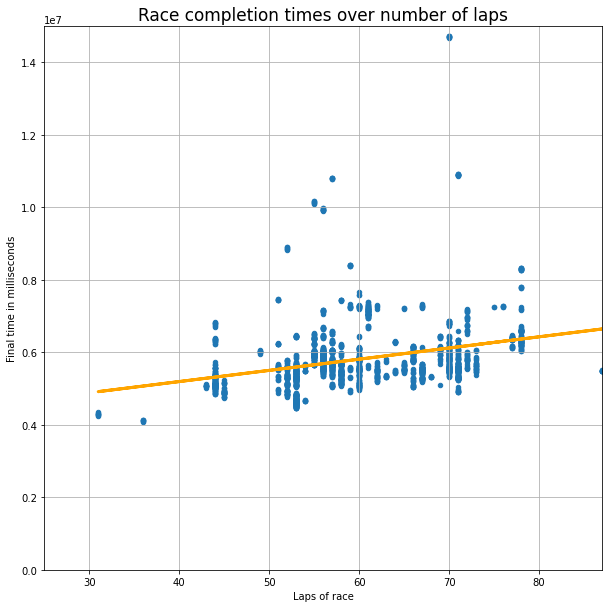

In [8]:
plt.figure(figsize=[10,10])
plt.xlim(25, 87)
plt.ylim(0, 15000000)
plt.title('Race completion times over number of laps', fontsize=17)
plt.scatter(x_train, y_train, s=20)
plt.plot(x_train, regr.predict(x_train), color='orange', linewidth=3)
plt.xlabel('Laps of race')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.savefig('finalTimeOverLaps.png')
plt.show()

In [13]:
#filename = 'model1.pkl'
#pickle.dump(regr, (filename,'wb'))


TypeError: file must have a 'write' attribute

In [55]:
lastRace2020 =result2[result2.raceId == 1047]
lastRace2020 = pd.merge(lastRace2020,construct,on='constructorId')
lastRace = lastRace2020[['positionOrder', 'driver', 'name_y',  'points', 'time_x']]
lastRace = lastRace.sort_values(by=['positionOrder', 'points'], ascending=True, ignore_index=True)
lastRace = lastRace.rename_axis('key', axis=0)
lastRace
#result = lastRace.to_json(orient='table')
#parsed = json.loads(result)
lastRace.to_json(r'.\lastRaceTable.json', orient='table', index=True)
#lastRace.to_dict(orient='records')